In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Import required libraries

import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,
    BatchNormalization, GlobalAveragePooling2D, GaussianNoise,
    Input, Reshape, MultiHeadAttention
)
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load Image File Paths & Labels

# Define dataset path
base_dir = '/content/drive/MyDrive/DL lab/Blood cell Cancer [ALL]'

# Define categories (folder names)
categories = {
    'Benign': 'Benign',
    'Malignant_Pre_B': '[Malignant] Pre-B',
    'Malignant_Pro_B': '[Malignant] Pro-B',
    'Malignant_early_Pre_B': '[Malignant] early Pre-B'
}

# Load image file paths and labels
file_paths = []
labels = []
for label, subfolder in categories.items():
    folder_path = os.path.join(base_dir, subfolder)
    for filename in os.listdir(folder_path):
        file_paths.append(os.path.join(folder_path, filename))
        labels.append(label)

In [3]:
# Create DataFrame
df = pd.DataFrame({'file_path': file_paths, 'label': labels})

# Print class distribution
print("Class distribution before oversampling:")
print(df['label'].value_counts())

Class distribution before oversampling:
label
Malignant_early_Pre_B    979
Malignant_Pre_B          955
Malignant_Pro_B          796
Benign                   512
Name: count, dtype: int64


<ipython-input-4-99051a3149c3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette='viridis')


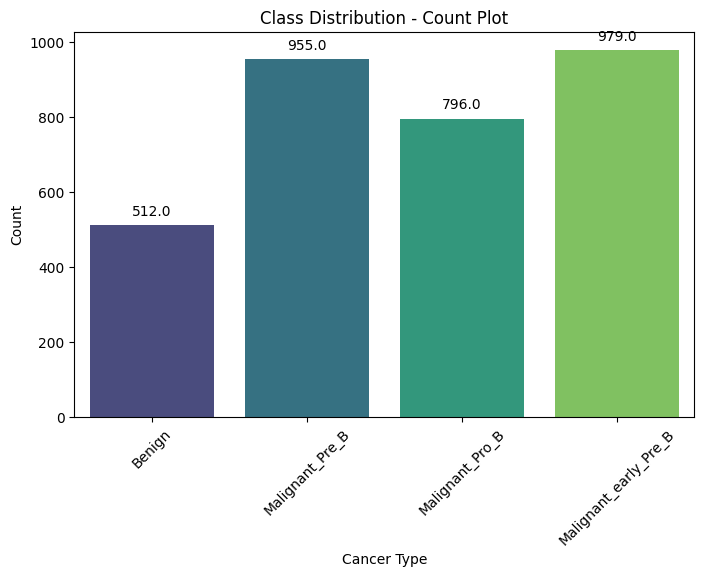

In [4]:
# Visualizing Class Distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=df, palette='viridis')
plt.title('Class Distribution - Count Plot')
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

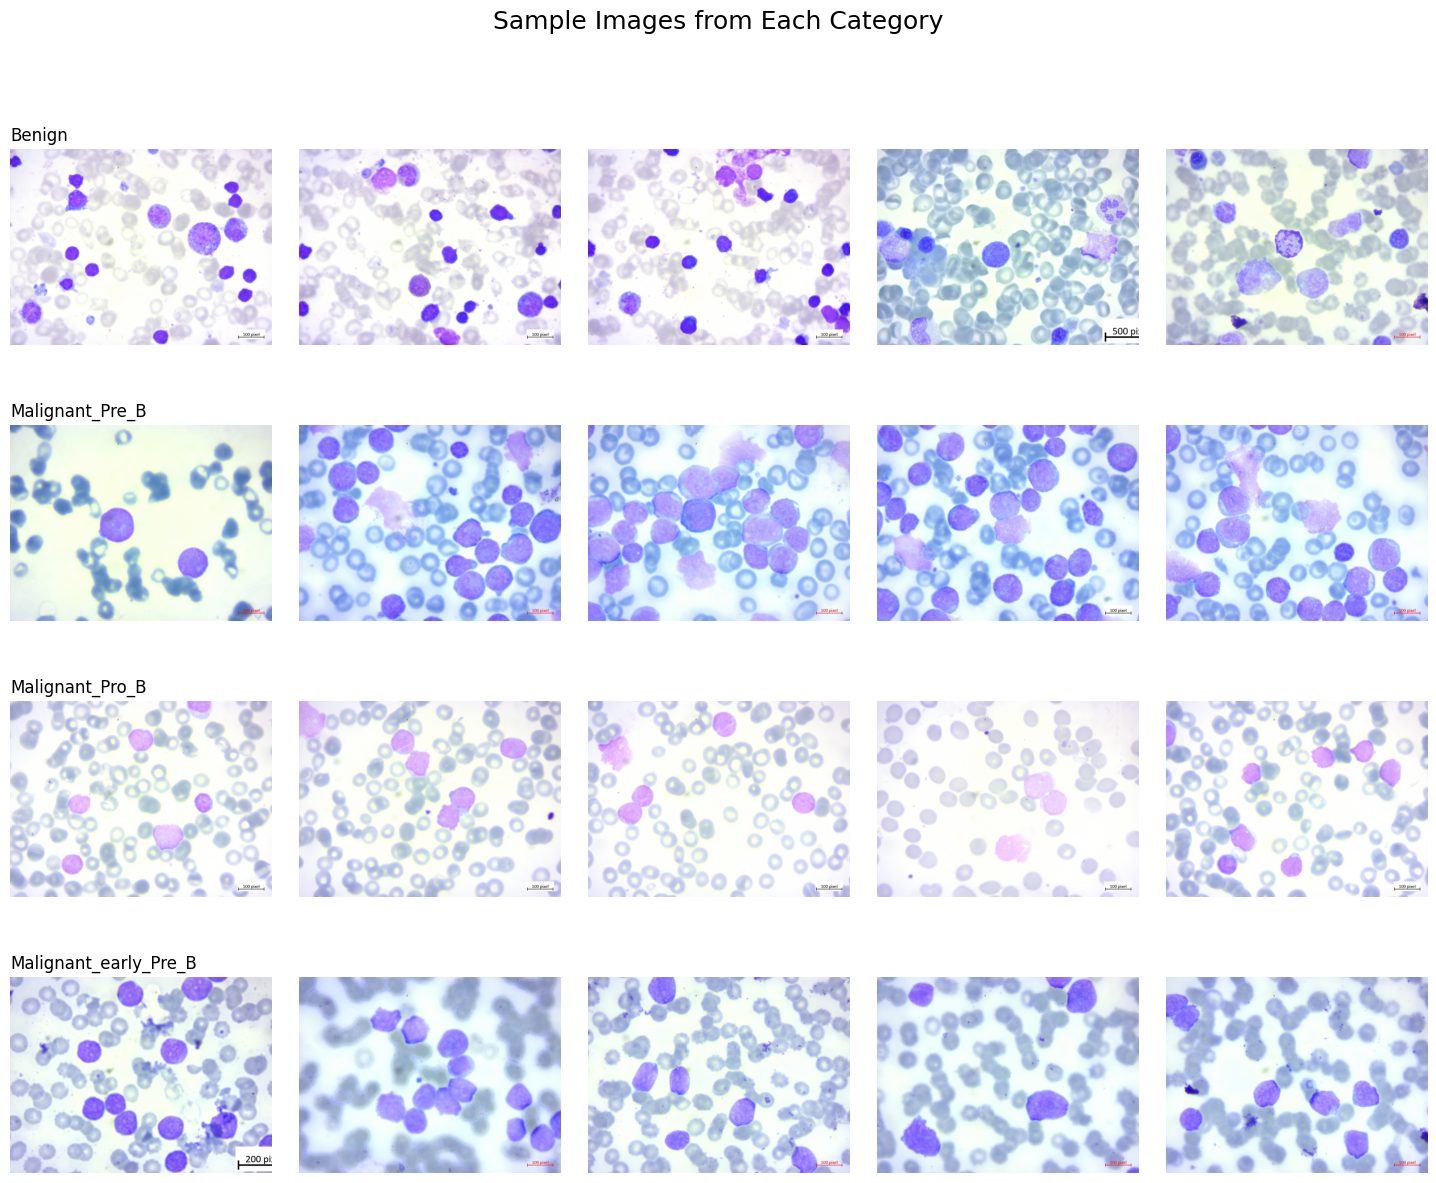

In [5]:
# Sample images from each category
num_images = 5
fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 12))
fig.suptitle('Sample Images from Each Category', fontsize=18, y=1.02, ha='center')

for i, (label, subfolder) in enumerate(categories.items()):
    category_images = df[df['label'] == label]['file_path'].tolist()
    selected_images = random.sample(category_images, num_images)

    for j, img_path in enumerate(selected_images):
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

        if j == 0:
            axes[i, j].set_title(label, fontsize=12, loc='left')

plt.tight_layout(pad=3.0, w_pad=2.0, h_pad=5.0)
plt.subplots_adjust(top=0.92)
plt.show()

In [6]:
# Handle Class Imbalance (Oversampling)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['file_path']], df['label'])
df_resampled = pd.DataFrame(X_resampled, columns=['file_path'])
df_resampled['label'] = y_resampled

# Print class distribution after oversampling
print("\nClass distribution after oversampling:")
print(df_resampled['label'].value_counts())


Class distribution after oversampling:
label
Benign                   979
Malignant_Pre_B          979
Malignant_Pro_B          979
Malignant_early_Pre_B    979
Name: count, dtype: int64


In [7]:
# Encode labels
le = LabelEncoder()
df_resampled['label_encoded'] = le.fit_transform(df_resampled['label'])
df_resampled = df_resampled[['file_path', 'label_encoded']]

In [8]:
# Splitting Data
train_df_new, temp_df_new = train_test_split(
    df_resampled, train_size=0.8, shuffle=True, random_state=42, stratify=df_resampled['label_encoded']
)
valid_df_new, test_df_new = train_test_split(
    temp_df_new, test_size=0.5, shuffle=True, random_state=42, stratify=temp_df_new['label_encoded']
)


In [9]:
# Convert Labels to String
train_df_new['label_encoded'] = train_df_new['label_encoded'].astype(str)
valid_df_new['label_encoded'] = valid_df_new['label_encoded'].astype(str)
test_df_new['label_encoded'] = test_df_new['label_encoded'].astype(str)

In [10]:
# Data Augmentation & Generators
batch_size = 16
img_size = (224, 224)

# Define the training data augmentation pipeline
tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new, x_col='file_path', y_col='label_encoded',
    target_size=img_size, class_mode='sparse',
    color_mode='rgb', shuffle=True, batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new, x_col='file_path', y_col='label_encoded',
    target_size=img_size, class_mode='sparse',
    color_mode='rgb', shuffle=True, batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new, x_col='file_path', y_col='label_encoded',
    target_size=img_size, class_mode='sparse',
    color_mode='rgb', shuffle=False, batch_size=batch_size
)

Found 3132 validated image filenames belonging to 4 classes.
Found 392 validated image filenames belonging to 4 classes.
Found 392 validated image filenames belonging to 4 classes.


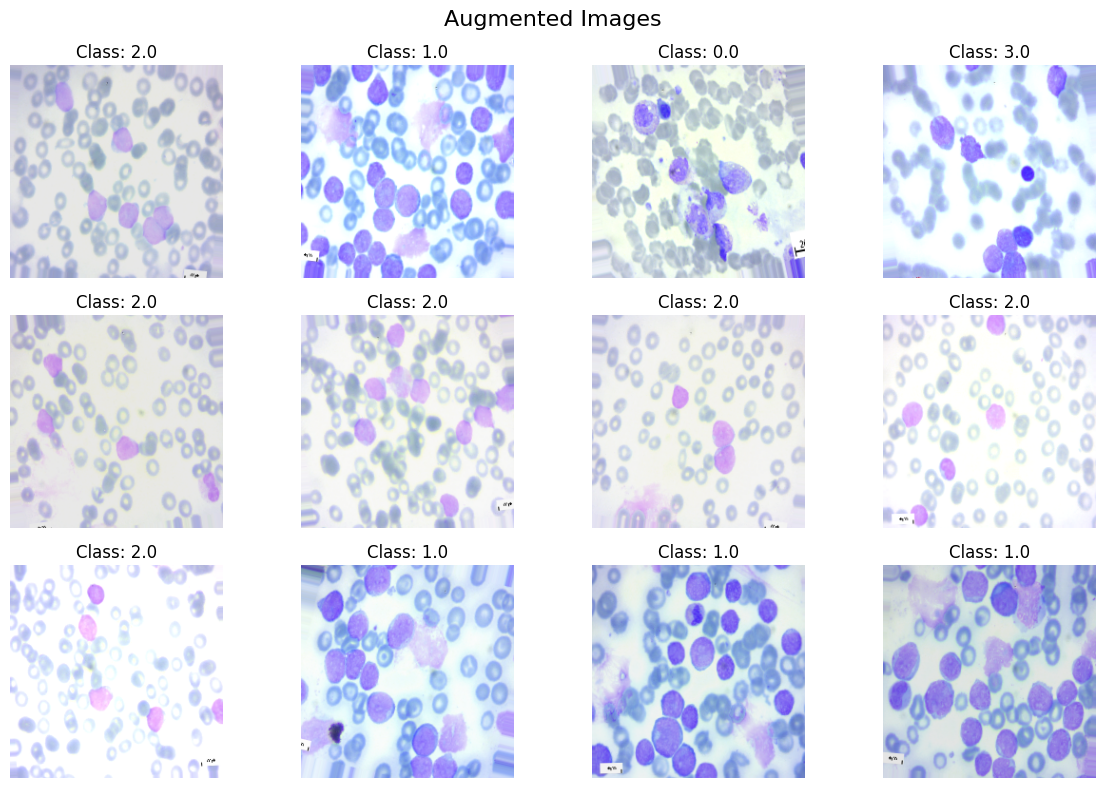

In [11]:
# Get a batch of augmented images
augmented_images, augmented_labels = next(train_gen_new)

# Plot the augmented images
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
    plt.title(f"Class: {augmented_labels[i]}")
plt.suptitle("Augmented Images", fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
# Function to create the model
def create_inceptionv3_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = InceptionV3(weights='imagenet', input_tensor=inputs, include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    height, width, channels = 5, 5, 2048
    x = Reshape((height * width, channels))(x)
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)
    attention_output = Reshape((height, width, channels))(attention_output)
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
# Create and compile the model
input_shape = (224, 224, 3)
cnn_model = create_inceptionv3_model(input_shape)
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [15]:
# Train the model
history = cnn_model.fit(train_gen_new, validation_data=valid_gen_new, epochs=10, callbacks=[early_stopping], verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1143s 6s/step - accuracy: 0.7734 - loss: 0.6427 - val_accuracy: 0.8189 - val_loss: 0.5767
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 120s 613ms/step - accuracy: 0.8904 - loss: 0.2910 - val_accuracy: 0.8520 - val_loss: 0.4974
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 108s 548ms/step - accuracy: 0.9118 - loss: 0.2545 - val_accuracy: 0.8622 - val_loss: 0.5369
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 108s 551ms/step - accuracy: 0.9364 - loss: 0.1740 - val_accuracy: 0.7066 - val_loss: 1.3180
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 143s 555ms/step - accuracy: 0.9326 - loss: 0.1873 - val_accuracy: 0.9337 - val_loss: 0.1984
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 140s 547ms/step - accuracy: 0.9562 - loss: 0.1409 - val_accuracy: 0.6403 - val_loss: 2.0176
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 107s 545ms/step - accuracy: 0.9274 - loss: 0.1936 - val_accuracy: 0.8622 - val_loss: 0.5325
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 107s 545ms/step - accuracy: 0.9339 - l

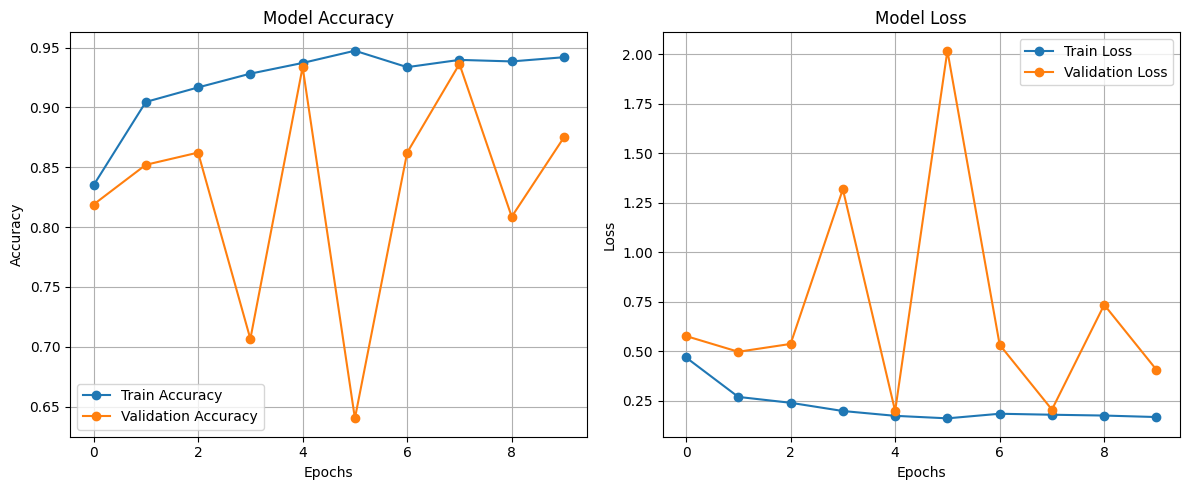

In [16]:
# Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [17]:
# Model Evaluation on Test Data
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step


In [18]:
# Classification Report
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.99      0.81      0.89        98
           1       0.99      0.99      0.99        98
           2       1.00      0.98      0.99        98
           3       0.81      0.98      0.89        98

    accuracy                           0.94       392
   macro avg       0.95      0.94      0.94       392
weighted avg       0.95      0.94      0.94       392



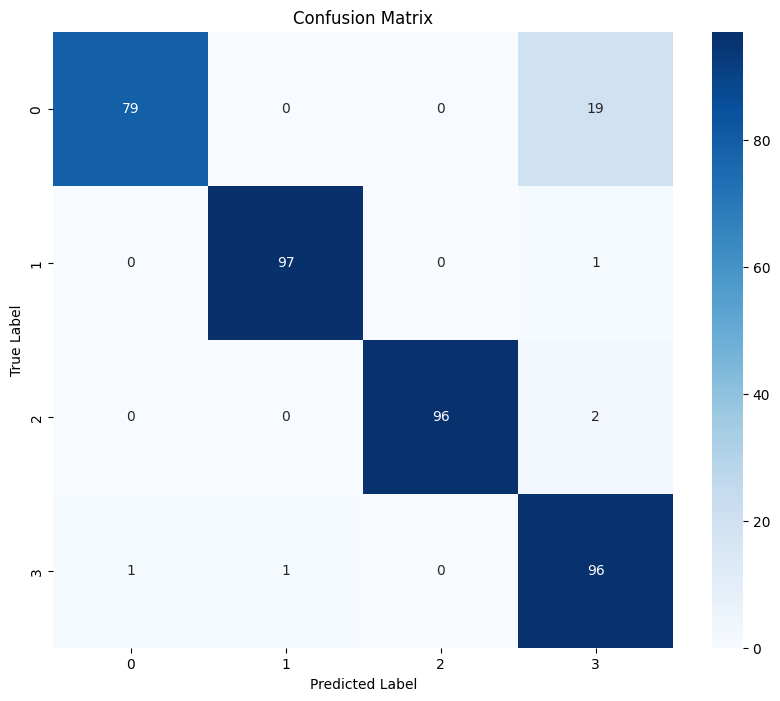

In [19]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
# Save Model and Training History
np.save('history_inception.npy', history.history)
cnn_model.save('inceptionv3_model.h5')


In [21]:
# Import necessary libraries
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
import tensorflow as tf

In [22]:
# Enable mixed precision training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [23]:
# Function to create the Xception-based model
def create_xception_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = Xception(weights='imagenet', input_tensor=inputs, include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]
    x = Reshape((height * width, channels))(x)
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)
    attention_output = Reshape((height, width, channels))(attention_output)
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [24]:
# Define input shape
input_shape = (224, 224, 3)
batch_size = 16

In [25]:
# Create the model
cnn_model = create_xception_model(input_shape)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [27]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [28]:
# Train the model
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 154s 648ms/step - accuracy: 0.7988 - loss: 0.5661 - val_accuracy: 0.9311 - val_loss: 0.2078
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 96s 491ms/step - accuracy: 0.9347 - loss: 0.2021 - val_accuracy: 0.6862 - val_loss: 1.1158
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 96s 491ms/step - accuracy: 0.9392 - loss: 0.1676 - val_accuracy: 0.9209 - val_loss: 0.2035
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 101s 516ms/step - accuracy: 0.9507 - loss: 0.1400 - val_accuracy: 0.9617 - val_loss: 0.1154
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 96s 490ms/step - accuracy: 0.9570 - loss: 0.1120 - val_accuracy: 0.8878 - val_loss: 0.3211
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 97s 493ms/step - accuracy: 0.9636 - loss: 0.1067 - val_accuracy: 0.9235 - val_loss: 0.2369
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 96s 490ms/step - accuracy: 0.9567 - loss: 0.1220 - val_accuracy: 0.9056 - val_loss: 0.2913


In [29]:
# Save the training history as a NumPy file for later analysis
np.save('history_xception.npy', history.history)

# Save the trained model in HDF5 format for future use
cnn_model.save('xception_model.h5')

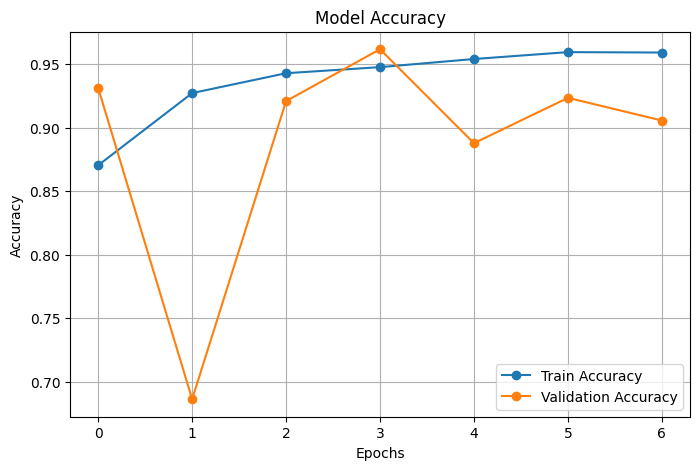

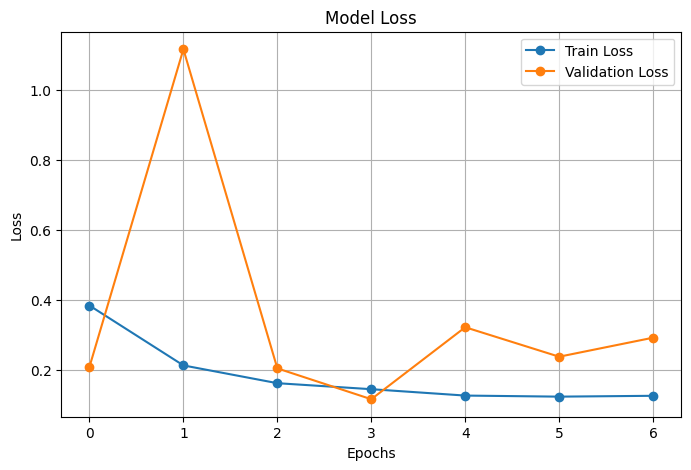

In [30]:
# Plot training & validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [31]:
# Evaluate model on test data
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step


In [32]:
# Print classification report
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.98      0.86      0.91        98
           1       1.00      0.97      0.98        98
           2       1.00      0.95      0.97        98
           3       0.83      1.00      0.91        98

    accuracy                           0.94       392
   macro avg       0.95      0.94      0.94       392
weighted avg       0.95      0.94      0.94       392



In [33]:
# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

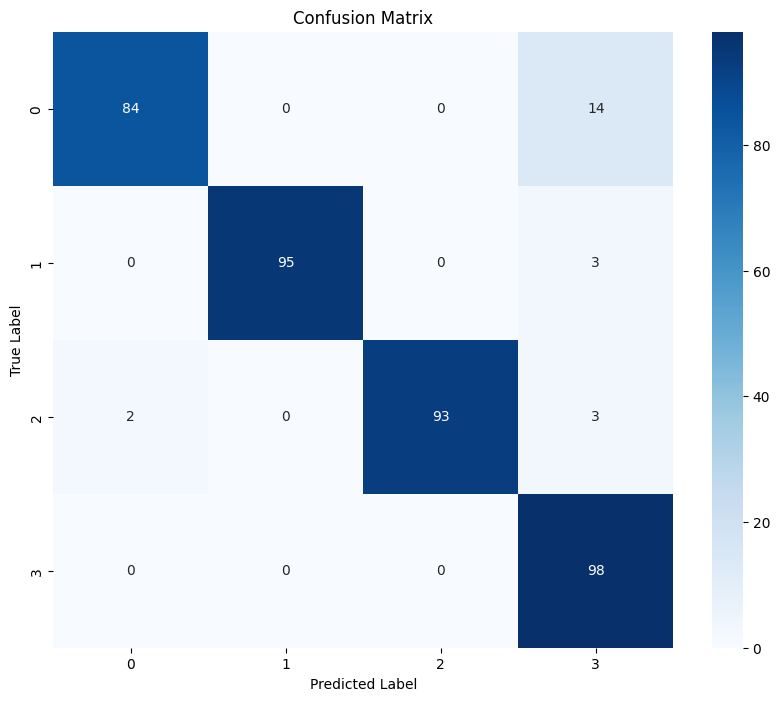

In [34]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_gen_new.class_indices.keys()),
            yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
# Import required libraries
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Function to create a MobileNet-based model
def create_mobilenet_model(input_shape):
    inputs = Input(shape=input_shape)  # Input layer

    # Load the MobileNet model with pre-trained weights, excluding the top layer
    base_model = MobileNet(weights='imagenet', input_tensor=inputs, include_top=False)

    # Freeze all layers of the base model to retain pre-trained features
    for layer in base_model.layers:
        layer.trainable = False

    # Extract output from the base model
    x = base_model.output

    # Reshape output to match the attention mechanism's input requirements
    height, width, channels = 7, 7, 1024
    x = Reshape((height * width, channels))(x)

    # Apply multi-head attention to capture spatial relationships
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)

    # Reshape attention output back to feature map dimensions
    attention_output = Reshape((height, width, channels))(attention_output)

    # Add Gaussian noise for regularization
    x = GaussianNoise(0.25)(attention_output)

    # Apply global average pooling to reduce dimensionality
    x = GlobalAveragePooling2D()(x)

    # Fully connected dense layer with ReLU activation
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch normalization for stable training
    x = GaussianNoise(0.25)(x)  # More Gaussian noise for regularization
    x = Dropout(0.25)(x)  # Dropout to prevent overfitting

    # Output layer with softmax activation for multi-class classification
    outputs = Dense(4, activation='softmax')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [45]:
# Define input shape
input_shape = (224, 224, 3)
batch_size=16

In [46]:
# Create model
cnn_model = create_mobilenet_model(input_shape)

<ipython-input-44-e9b34973a585>:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', input_tensor=inputs, include_top=False)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [47]:
# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [56]:
# Train the model
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,  # Number of training epochs
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 92s 469ms/step - accuracy: 0.9778 - loss: 0.0591 - val_accuracy: 0.7934 - val_loss: 0.7416
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 91s 464ms/step - accuracy: 0.9844 - loss: 0.0481 - val_accuracy: 0.8469 - val_loss: 0.5870
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 95s 481ms/step - accuracy: 0.9862 - loss: 0.0436 - val_accuracy: 0.9286 - val_loss: 0.2318
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 90s 461ms/step - accuracy: 0.9837 - loss: 0.0395 - val_accuracy: 0.9847 - val_loss: 0.0600
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 89s 454ms/step - accuracy: 0.9791 - loss: 0.0620 - val_accuracy: 0.9719 - val_loss: 0.1045
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 91s 463ms/step - accuracy: 0.9852 - loss: 0.0359 - val_accuracy: 0.9617 - val_loss: 0.1344
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 92s 470ms/step - accuracy: 0.9897 - loss: 0.0323 - val_accuracy: 0.9847 - val_loss: 0.0429
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 91s 465ms/step - accuracy: 0.9888 - loss: 0

In [57]:
# Save training history
np.save('history_mobilenet.npy', history.history)
# Save the trained model
cnn_model.save('mobilenet_model.h5')

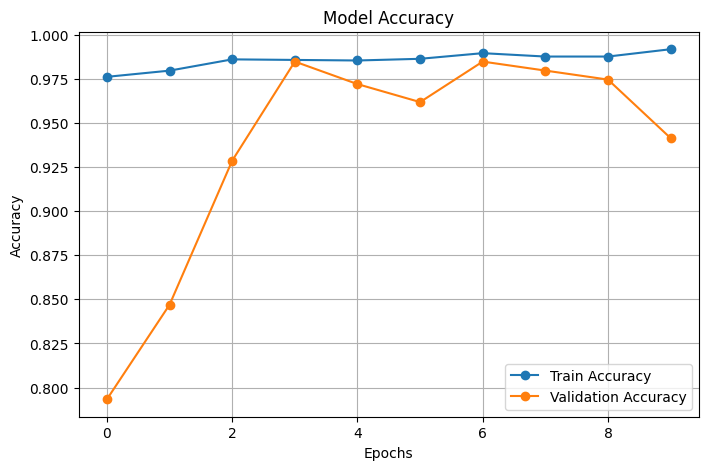

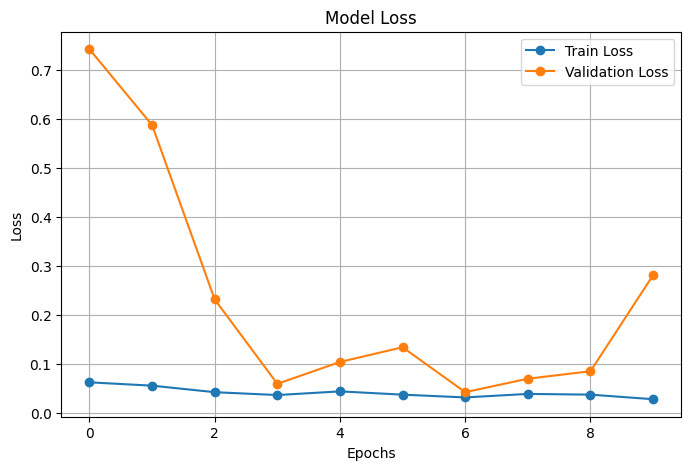

In [58]:
# Plot training & validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [59]:
# Evaluate model on test data
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step


In [60]:
# Print classification report
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        98
           1       0.99      1.00      0.99        98
           2       1.00      1.00      1.00        98
           3       1.00      0.96      0.98        98

    accuracy                           0.99       392
   macro avg       0.99      0.99      0.99       392
weighted avg       0.99      0.99      0.99       392



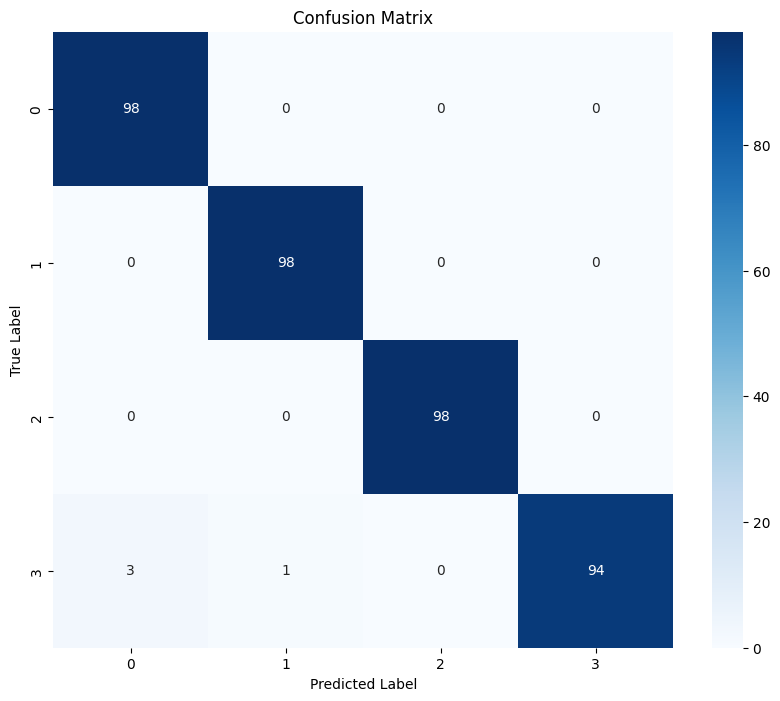

In [61]:
# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_gen_new.class_indices.keys()),
            yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
